In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [16]:
datasets_dir = os.path.join(os.getcwd(), 'datasets')
file_name = 'JPM_2006-01-01_to_2018-01-01.csv'
file_path = os.path.join(datasets_dir, file_name)
df = pd.read_csv(file_path)

In [17]:
diff_close_series = df['Close'].diff().dropna()

In [18]:
lagdata = pd.concat(
    [diff_close_series.shift(i) for i in range(5, -1, -1)],
    axis=1
).dropna()
lagdata.columns = [f'lag_{i}' for i in range(5, -1, -1)]
X = lagdata.iloc[:, 1:].values  
y = lagdata.iloc[:, 0].values

In [19]:
#diffcloseseires = df['Close'].diff().dropna()

In [20]:
scalerx = StandardScaler()
xscaled = scalerx.fit_transform(X)

In [21]:
X_reshaped = xscaled.reshape((xscaled.shape[0], xscaled.shape[1], 1))

In [22]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_reshaped.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2025-02-20 23:18:21.365673: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/ryu/code/minorproject/VENV/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.fit(X_reshaped, y, epochs=200, batch_size=8, verbose=0)

In [24]:
ypredlist = []

In [25]:
for i in range(len(xscaled)):
    X_input = xscaled[i].reshape((1, X_reshaped.shape[1], 1))
    
    y_pred_raw = model.predict(X_input, verbose=0)
    ypredlist.append(y_pred_raw[0][0]) 

In [26]:
y_pred = np.array(ypredlist)

scaler_y = StandardScaler()
y_scaled_actual = scaler_y.fit_transform(y.reshape(-1, 1))
y_scaled_pred = scaler_y.transform(y_pred.reshape(-1, 1))

In [27]:
mse = mean_squared_error(y_scaled_actual, y_scaled_pred)
r2 = r2_score(y_scaled_actual, y_scaled_pred)

In [28]:
print(f"LSTM MSE: {mse:.6f}")
print(f"LSTM R2: {r2:.6f}")

LSTM MSE: 0.516572
LSTM R2: 0.483428


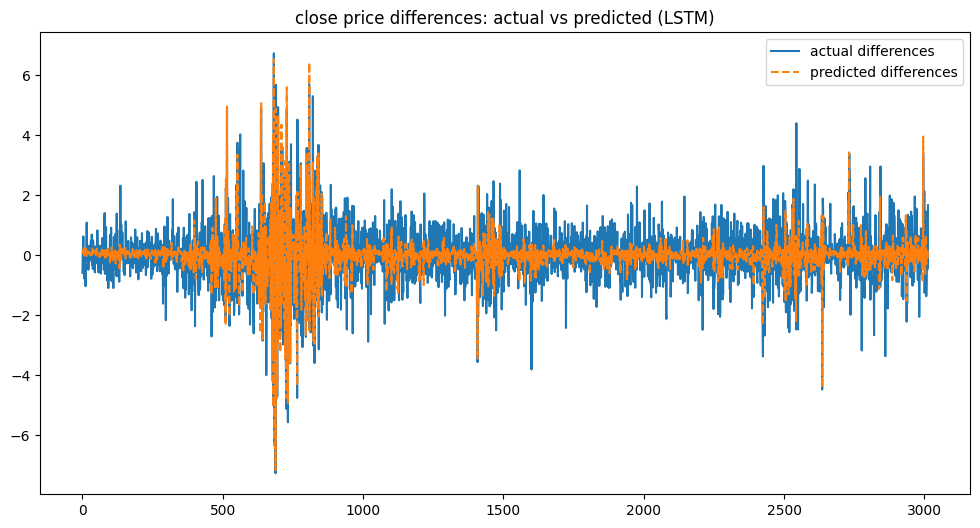

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(y_scaled_actual, label='actual differences')
plt.plot(y_scaled_pred, label='predicted differences', linestyle='dashed')
plt.title("close price differences: actual vs predicted (LSTM)")
plt.legend()
plt.show()